# Download Libraries

In [1]:
!pip -q install torch torchaudio librosa soundfile pandas scikit-learn tqdm matplotlib pyyaml

# Simple config + Helper

## Import Libraries

In [2]:
import os, sys, json, math, random, zipfile, tarfile, urllib.request, re, shutil
from pathlib import Path
from collections import Counter
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
import librosa

# Pytorch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import f1_score, confusion_matrix


## Config

In [3]:
# Put the release asset URLs here (multiple ZIPs are supported)
DATA_RELEASE_URLS = [
    "https://github.com/vistec-AI/dataset-releases/releases/download/v1/studio1-10.zip",
    "https://github.com/vistec-AI/dataset-releases/releases/download/v1/studio11-20.zip",
    "https://github.com/vistec-AI/dataset-releases/releases/download/v1/studio21-30.zip",
    "https://github.com/vistec-AI/dataset-releases/releases/download/v1/studio31-40.zip",
    "https://github.com/vistec-AI/dataset-releases/releases/download/v1/studio41-50.zip",
    "https://github.com/vistec-AI/dataset-releases/releases/download/v1/studio51-60.zip",
    "https://github.com/vistec-AI/dataset-releases/releases/download/v1/studio61-70.zip",
    "https://github.com/vistec-AI/dataset-releases/releases/download/v1/studio71-80.zip",
    "https://github.com/vistec-AI/dataset-releases/releases/download/v1/zoom1-10.zip",
    "https://github.com/vistec-AI/dataset-releases/releases/download/v1/zoom11-20.zip",
]

# Label JSON
LABEL_JSON_URL = "https://github.com/vistec-AI/dataset-releases/releases/download/v1/emotion_label.json"

# Only use FLAC audio
AUDIO_EXTS = {".flac", ".FLAC"}

# Subset filters we definitely want
USE_ENV  = {"studio", "zoom"}
USE_MICS = {"clip", "con", "mic"}
USE_SESS = {"script", "impro"}   # both sessions are allowed; we filter again when building metadata
AGREEMENT_MIN = 0.6              # quality threshold from emotion_label.json

# Project paths
PROJECT_DIR = Path("/content/emotion_ser")
RAW_DIR     = PROJECT_DIR / "raw"   # extracted audio + label JSON
DATA_DIR    = PROJECT_DIR / "data"  # metadata.csv, etc.
PROJECT_DIR.mkdir(parents=True, exist_ok=True)
RAW_DIR.mkdir(exist_ok=True)
DATA_DIR.mkdir(exist_ok=True)

# Audio / training defaults
SR         = 16000   # we will resample to 16 kHz
MAX_SEC    = 4.0
N_MELS     = 64
BATCH_SIZE = 32
EPOCHS     = 25
LR         = 1e-3
SEED       = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Helper

In [4]:

# download multiple archives + recursive extraction
def _download_one(url: str, out_dir: Path) -> Path:
    """Download a single URL into out_dir; skip if already exists."""
    out_dir.mkdir(parents=True, exist_ok=True)
    fname = url.split("/")[-1].split("?")[0]
    dst = out_dir / fname
    if not dst.exists():
        print(f"Downloading: {fname}")
        urllib.request.urlretrieve(url, dst)
    else:
        print(f"Already exists: {fname}")
    return dst

def _extract_one(archive_path: Path, out_dir: Path) -> bool:
    """Extract .zip / .tar(.gz) archive into out_dir."""
    try:
        if archive_path.suffix == ".zip":
            with zipfile.ZipFile(archive_path, "r") as zf:
                zf.extractall(out_dir)
            return True
        if archive_path.suffix in [".tar", ".gz", ".tgz", ".tar.gz"]:
            with tarfile.open(archive_path, "r:*") as tf:
                tf.extractall(out_dir)
            return True
    except Exception as e:
        print("Extraction error:", archive_path, e)
    return False

def extract_recursive(base_dir: Path, max_depth: int = 3):
    """Recursively extract nested archives up to max_depth levels."""
    for _ in range(max_depth):
        archives = [p for p in base_dir.rglob("*")
                    if p.is_file() and p.suffix in [".zip", ".tar", ".gz", ".tgz"]]
        if not archives:
            break
        for arch in archives:
            ok = _extract_one(arch, arch.parent)
            if ok:
                try: arch.unlink()
                except: pass

def download_all_and_extract_any(urls, out_dir: Path):
    """Download all URLs and extract them; also extract nested archives."""
    if not urls:
        raise ValueError("DATA_RELEASE_URLS is empty. Please provide the asset URLs.")
    for url in urls:
        p = _download_one(url, out_dir)
        _extract_one(p, out_dir)
    extract_recursive(out_dir, max_depth=3)
    print("Extracted into:", out_dir)


In [5]:
# download emotion_label.json
def ensure_emotion_label_json(out_dir: Path, url: str) -> Path:
    """Ensure emotion_label.json is present under out_dir."""
    out_dir.mkdir(parents=True, exist_ok=True)
    dst = out_dir / "emotion_label.json"
    if not dst.exists():
        print("Downloading emotion_label.json")
        urllib.request.urlretrieve(url, dst)
    else:
        print("emotion_label.json already present")
    return dst

In [6]:
# list .flac files only
def list_audio_flac(base_dir: Path):
    """Return all FLAC files under base_dir."""
    return [p for p in base_dir.rglob("*") if p.is_file() and p.suffix in AUDIO_EXTS]


In [7]:
# quick tree print
def print_tree(base: Path, depth: int = 2, max_entries: int = 200):
    """Print a shallow tree for inspection."""
    print(f"== TREE of {base} ==")
    cnt = 0
    for p in base.rglob("*"):
        rel = p.relative_to(base)
        if len(rel.parts) <= depth:
            print(rel)
            cnt += 1
            if cnt >= max_entries:
                print("... (trimmed)")
                break

In [8]:
# iterate entries no matter if value is a list[dict] or a dict
def iter_label_entries(emo_json):
    """
    Yield (basename, entry_dict) from emotion_label.json.
    THAI SER stores each key's value as a list with a single dict in most cases.
    """
    for k, v in emo_json.items():
        if isinstance(v, list):
            if not v:
                continue
            entry = v[0]
            if isinstance(entry, dict):
                yield k, entry
        elif isinstance(v, dict):
            yield k, v

In [9]:
# parse fields from filename
# Example names:
#   s002_clip_actor003_impro1_1.flac
#   s010_con_actor057_script3_2_5b.flac
NAME_PAT = re.compile(
    r'^(?P<rec>[sz]\d{3})_(?P<mic>clip|con|middle|mic)_actor(?P<actor>\d{3})_(?P<session>script|impro)',
    re.IGNORECASE
)

def parse_name_fields(basename: str):
    """
    Parse (env, mic, session, actor) from a THAI SER filename.
    env: 'studio' if rec starts with 's', else 'zoom'
    mic: clip/con/middle/mic
    session: script or impro
    actor: actorXYZ
    """
    m = NAME_PAT.match(basename)
    if not m:
        return None
    g = m.groupdict()
    env = "studio" if g["rec"].lower().startswith("s") else "zoom"
    mic = g["mic"].lower()
    session = g["session"].lower()
    actor = f'actor{g["actor"]}'
    return env, mic, session, actor

# Download, Unpack, and Load Labels

In [10]:
# Download all archives and extract (including nested archives)
download_all_and_extract_any(DATA_RELEASE_URLS, RAW_DIR)

Downloading: studio1-10.zip
Downloading: studio11-20.zip
Downloading: studio21-30.zip
Downloading: studio31-40.zip
Downloading: studio41-50.zip
Downloading: studio51-60.zip
Downloading: studio61-70.zip
Downloading: studio71-80.zip
Downloading: zoom1-10.zip
Downloading: zoom11-20.zip
Extracted into: /content/emotion_ser/raw


In [11]:
# Ensure label JSON is present
LABEL_JSON = ensure_emotion_label_json(RAW_DIR, LABEL_JSON_URL)
print("Label JSON at:", LABEL_JSON)

Label JSON at: /content/emotion_ser/raw/emotion_label.json


In [12]:
# Quick directory inspection
print_tree(RAW_DIR, depth=2)

== TREE of /content/emotion_ser/raw ==
studio059
studio016
zoom020
studio066
studio079
studio045
studio036
zoom017
zoom005
studio027
studio065
zoom011
studio069
zoom006
studio071
studio062
studio012
zoom013
studio011
studio046
zoom002
studio058
studio052
studio005
studio024
studio056
studio044
zoom015
studio003
studio017
zoom019
studio010
studio068
zoom014
studio006
studio018
studio033
studio042
studio023
studio077
studio060
studio037
zoom018
studio054
studio041
studio007
studio020
studio035
studio030
studio051
studio043
studio015
studio061
studio053
studio019
studio004
zoom009
studio008
studio076
emotion_label.json
zoom003
studio025
studio049
studio078
studio022
zoom012
studio001
studio009
zoom004
zoom010
studio021
studio057
studio048
studio073
studio013
studio026
studio050
studio034
studio039
studio029
studio064
zoom008
studio040
studio032
studio070
studio074
studio014
studio031
zoom007
studio028
studio038
studio047
studio002
studio067
zoom001
studio075
studio063
studio055
zoom016
st

In [13]:
# Load the emotion_label.json
with open(LABEL_JSON, "r", encoding="utf-8") as f:
    emo_dict = json.load(f)

print(f"Label entries in emotion_label.json: {len(emo_dict):,}")

Label entries in emotion_label.json: 27,854


In [14]:
# Count FLAC files found
flacs = list_audio_flac(RAW_DIR)
print(f"FLAC files found under RAW_DIR: {len(flacs):,}")

FLAC files found under RAW_DIR: 61,972


In [15]:
# Process emotion labels, filter data, and find corresponding audio files
rows = []
kept, skipped_no_file, skipped_filter, skipped_agree = 0, 0, 0, 0

for base, entry in iter_label_entries(emo_dict):
    # parse filename fields
    parsed = parse_name_fields(Path(base).name)
    if not parsed:
        skipped_filter += 1
        continue
    env, mic, session, actor = parsed

    # subset filtering
    if env not in USE_ENV or mic not in USE_MICS or session not in USE_SESS:
        skipped_filter += 1
        continue

    # label + agreement
    label = entry.get("majority_emo", None)
    agreement = entry.get("agreement", None)
    if label is None:
        skipped_filter += 1
        continue
    if isinstance(agreement, (int, float)) and agreement < AGREEMENT_MIN:
        skipped_agree += 1
        continue

    # find actual file (by basename under RAW_DIR)
    cands = list(RAW_DIR.rglob(Path(base).name))
    if not cands:
        skipped_no_file += 1
        continue

    path = str(cands[0].resolve())
    rows.append({
        "path": path,
        "label": label,         # keep English labels for now
        "speaker_id": actor,
        "env": env, "mic": mic, "session": session,
        "agreement": agreement
    })
    kept += 1

print(f"Kept: {kept} | Skipped(no file): {skipped_no_file} | Skipped(filter): {skipped_filter} | Skipped(agreement): {skipped_agree}")


Kept: 21018 | Skipped(no file): 0 | Skipped(filter): 0 | Skipped(agreement): 6836


In [16]:
# Create DataFrame from processed data and check if it's empty
df = pd.DataFrame(rows)
if df.empty:
    raise RuntimeError("No samples after filtering. Consider lowering AGREEMENT_MIN or check your URLs.")

In [17]:
# Speaker-independent split
uniq_spk = df["speaker_id"].unique().tolist()
random.shuffle(uniq_spk)
n = len(uniq_spk)
tr_end = int(0.7*n); va_end = int(0.85*n)
train_spk = set(uniq_spk[:tr_end]); val_spk = set(uniq_spk[tr_end:va_end]); test_spk = set(uniq_spk[va_end:])

In [18]:
# Assign splits (train, val, test) based on speaker ID
def choose_split(spk):
    if spk in train_spk: return "train"
    if spk in val_spk:   return "val"
    return "test"

df["split"] = df["speaker_id"].apply(choose_split)

In [19]:
# Save metadata
meta_out = DATA_DIR / "metadata.csv"
df.to_csv(meta_out, index=False, encoding="utf-8-sig")
print("Saved metadata to:", meta_out)
print(df["split"].value_counts())
print("Labels:", df["label"].value_counts())

Saved metadata to: /content/emotion_ser/data/metadata.csv
split
train    14691
test      3205
val       3122
Name: count, dtype: int64
Labels: label
Frustrated    6222
Neutral       6180
Happy         3635
Angry         2713
Sad           2266
other            2
Name: count, dtype: int64


# Dataset + Augment + Feature (Log-Mel)

In [20]:
# Basic audio utils
def load_mono(path: str, sr: int, max_sec: float, do_augment: bool = False):
    """Load audio, resample to `sr`, pad/crop to `max_sec` seconds, and (optionally) augment."""
    # read (supports FLAC natively via soundfile)
    y, s = sf.read(path, dtype="float32", always_2d=False)
    if y.ndim > 1:
        y = np.mean(y, axis=1)  # to mono

    # resample to target SR
    if s != sr:
        y = librosa.resample(y, orig_sr=s, target_sr=sr)

    # data augmentation (lightweight for baseline)
    if do_augment:
        y = augment_waveform(y, sr)

    # pad/crop to fixed length
    max_len = int(sr * max_sec)
    if len(y) < max_len:
        y = np.pad(y, (0, max_len - len(y)))
    else:
        y = y[:max_len]

    # amplitude safe-guard
    y = np.clip(y, -1.0, 1.0)
    return y

def augment_waveform(y: np.ndarray, sr: int):
    """Random waveform-level augmentations: speed, noise, gain."""
    # time-stretch ~30% (use keyword args to avoid librosa API differences)
    if random.random() < 0.30:
        rate = random.choice([0.9, 1.1])
        try:
            y = librosa.effects.time_stretch(y=y, rate=rate)
        except TypeError:
            # Fallback: some librosa versions expect positional or differ
            y = librosa.effects.time_stretch(y, rate)
        except Exception:
            pass  # if anything odd happens, skip stretch

    # random gain ~30%
    if random.random() < 0.30:
        gain = 10 ** (random.uniform(-3, 3) / 20.0)
        y = y * gain

    # light Gaussian noise ~30%
    if random.random() < 0.30:
        noise = np.random.randn(len(y)).astype(np.float32)
        y = y + 0.005 * noise

    return y

In [21]:
# Feature extraction
def wav_to_logmel(
    y: np.ndarray,
    sr: int,
    n_mels: int = 64,
    n_fft: int = 1024,
    hop_length: int = 160,
    win_length: int = 400
) -> np.ndarray:
    """
    Compute log-mel spectrogram.
    Returns float32 array of shape [n_mels, T], normalized per-utterance.
    """
    melspec = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length,
        n_mels=n_mels, power=2.0
    )
    logmel = librosa.power_to_db(melspec + 1e-9)
    # per-utterance standardization
    logmel = (logmel - logmel.mean()) / (logmel.std() + 1e-9)
    return logmel.astype(np.float32)

In [22]:
# PyTorch Dataset
class EmotionDataset(Dataset):
    """
    Expects a DataFrame with columns:
      - path: absolute path to .flac
      - label: class name (string)
      - split: 'train' | 'val' | 'test'
    Optional columns:
      - speaker_id, env, mic, session, intensity, agreement (kept for analysis)
    """
    def __init__(self, meta_df: pd.DataFrame, split: str, label_map=None, train: bool = True,
                 sr: int = 16000, max_sec: float = 4.0, n_mels: int = 64):
        super().__init__()
        self.df = meta_df[meta_df["split"] == split].reset_index(drop=True)
        self.train = train
        self.sr = sr
        self.max_sec = max_sec
        self.n_mels = n_mels

        if label_map is None:
            classes = sorted(self.df["label"].unique().tolist())
            self.label_map = {c: i for i, c in enumerate(classes)}
        else:
            self.label_map = label_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        path = row["path"]
        y = load_mono(path, sr=self.sr, max_sec=self.max_sec, do_augment=self.train)
        feat = wav_to_logmel(y, sr=self.sr, n_mels=self.n_mels)  # [n_mels, T]
        x = torch.from_numpy(feat)                                # float32
        y_lab = self.label_map[row["label"]]
        return x, y_lab

In [23]:
# Dataloaders
def make_loaders(meta_df: pd.DataFrame, batch_size: int = 32,
                 sr: int = 16000, max_sec: float = 4.0, n_mels: int = 64):
    """
    Create train/val/test DataLoaders and a shared label_map.
    """
    classes = sorted(meta_df["label"].unique().tolist())
    label_map = {c: i for i, c in enumerate(classes)}

    ds_tr = EmotionDataset(meta_df, "train", label_map, train=True,
                           sr=sr, max_sec=max_sec, n_mels=n_mels)
    ds_va = EmotionDataset(meta_df, "val",   label_map, train=False,
                           sr=sr, max_sec=max_sec, n_mels=n_mels)
    ds_te = EmotionDataset(meta_df, "test",  label_map, train=False,
                           sr=sr, max_sec=max_sec, n_mels=n_mels)

    def collate_fn(batch):
        xs, ys = zip(*batch)                # xs: [B, n_mels, T] (var T fixed by MAX_SEC), ys: labels

        # pad along time axis to max T in this batch
        T_max = max(x.shape[1] for x in xs)
        xs_pad = []
        for x in xs:
            if x.shape[1] < T_max:
                pad_T = T_max - x.shape[1]
                x = F.pad(x, (0, pad_T))    # pad right on time axis
            xs_pad.append(x)

        xs = torch.stack(xs, dim=0)         # [B, n_mels, T]
        ys = torch.tensor(ys, dtype=torch.long)
        return xs, ys

    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True,  num_workers=2,
                       collate_fn=collate_fn, drop_last=True)
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, num_workers=2,
                       collate_fn=collate_fn)
    dl_te = DataLoader(ds_te, batch_size=batch_size, shuffle=False, num_workers=2,
                       collate_fn=collate_fn)
    return dl_tr, dl_va, dl_te, label_map


In [24]:
# Create DataLoaders from metadata.csv
meta_path = DATA_DIR / "metadata.csv"

df = pd.read_csv(meta_path)

In [25]:
# Build loaders
dl_tr, dl_va, dl_te, label_map = make_loaders(
    df, batch_size=BATCH_SIZE, sr=SR, max_sec=MAX_SEC, n_mels=N_MELS
)

print("Splits -> train:", len(dl_tr.dataset), ", val:", len(dl_va.dataset), ", test:", len(dl_te.dataset))
print("Classes:", label_map)

Splits -> train: 14691 , val: 3122 , test: 3205
Classes: {'Angry': 0, 'Frustrated': 1, 'Happy': 2, 'Neutral': 3, 'Sad': 4, 'other': 5}


# Model (CNN-BiLSTM-Attention)

In [26]:
# Count trainable parameters
def count_parameters(model: nn.Module) -> int:
    """Return the number of trainable parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [27]:
# Conv block: 2D conv over [mel x time] with BN, ReLU, MaxPool
class ConvBlock(nn.Module):
    """
    A standard Conv2D block:
      Conv2d(k=3, padding=1) → BatchNorm → ReLU → MaxPool(2x2)
    Reduces both frequency and time dims by /2.
    """
    def __init__(self, cin: int, cout: int):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(cin, cout, kernel_size=3, padding=1),
            nn.BatchNorm2d(cout),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2))
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, C, F, T]
        return self.block(x)

In [28]:
# Attention pooling over time
class AttnPool(nn.Module):
    """
    Simple additive attention over the time axis.
    Given x: [B, T, D], produces:
      - attention weights w: [B, T]
      - pooled vector      z: [B, D]  = sum_t (w_t * x_t)
    """
    def __init__(self, dim: int):
        super().__init__()
        self.attn = nn.Linear(dim, 1)

    def forward(self, x: torch.Tensor):
        # x: [B, T, D]
        w = self.attn(x).squeeze(-1)      # [B, T]
        w = torch.softmax(w, dim=1)       # normalize over time
        pooled = torch.einsum("btd,bt->bd", x, w)  # weighted sum over time
        return pooled, w                        # pooled features and weights

In [29]:
# Main model: CNN → BiLSTM → Attention → Classifier
class CNNBiLSTMAttn(nn.Module):
    """
    Input:  log-mel spectrogram  x ∈ [B, n_mels, T]
    Stages:
      1) reshape to [B, 1, n_mels, T]
      2) three Conv2D blocks       → [B, 128, n_mels/8, T/8]
      3) flatten freq axis + project to proj_dim per time step
      4) BiLSTM over time          → [B, T/8, 2 * hidden]
      5) Attention pooling over time
      6) Linear head → logits      → [B, n_classes]
    """
    def __init__(
        self,
        n_mels: int = 64,
        n_classes: int = 5,
        lstm_hidden: int = 128,
        proj_dim: int = 256,
        num_lstm_layers: int = 2,
        dropout: float = 0.2
    ):
        super().__init__()

        # CNN backbone downsamples F and T by /8 overall
        self.cnn = nn.Sequential(
            ConvBlock(1, 32),    # [B, 1,   F,   T] → [B, 32,  F/2, T/2]
            ConvBlock(32, 64),   # [B, 32, F/2, T/2] → [B, 64,  F/4, T/4]
            ConvBlock(64, 128),  # [B, 64, F/4, T/4] → [B, 128, F/8, T/8]
        )

        # Project (channels * freq') → proj_dim per time step
        self.proj = nn.Linear((n_mels // 8) * 128, proj_dim)

        # Temporal modeling with BiLSTM
        self.lstm = nn.LSTM(
            input_size=proj_dim,
            hidden_size=lstm_hidden,
            num_layers=num_lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )

        # Attention pooling over time
        self.attn = AttnPool(lstm_hidden * 2)

        # Classifier head
        self.dropout = nn.Dropout(dropout)
        self.head = nn.Linear(lstm_hidden * 2, n_classes)

        # Kaiming init for conv layers
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: [B, n_mels, T]  (float32)
        return: logits [B, n_classes]
        """
        # Add a channel dim for Conv2D
        x = x.unsqueeze(1)              # [B, 1, n_mels, T]
        x = self.cnn(x)                 # [B, 128, n_mels/8, T/8]

        # Prepare sequence for LSTM: collapse [C, F'] per time step
        B, C, Fp, Tp = x.shape
        x = x.permute(0, 3, 1, 2).contiguous()   # [B, Tp, C, Fp]
        x = x.view(B, Tp, C * Fp)                # [B, Tp, C*Fp]
        x = self.proj(x)                         # [B, Tp, proj_dim]

        # Temporal modeling
        x, _ = self.lstm(x)                      # [B, Tp, 2*hidden]

        # Attention pooling
        z, attw = self.attn(x)                   # z: [B, 2*hidden]

        # Classification head
        z = self.dropout(z)
        logits = self.head(z)                    # [B, n_classes]
        return logits

In [30]:
# ---- Safe model instantiation ----
# We try to infer num_classes even if label_map is not yet created.
def infer_num_classes_fallback() -> int:
    """
    Try to determine number of classes.
    Priority:
      1) label_map (created by make_loaders)
      2) df['label'].nunique() (if df exists)
    """
    if 'label_map' in globals():
        return len(label_map)
    if 'df' in globals():
        return int(pd.Series(df['label']).nunique())
    raise RuntimeError(
        "Cannot infer num_classes. Run the metadata-building cell and make_loaders(...) first, "
        "so that 'label_map' or 'df' is available."
    )

num_classes = infer_num_classes_fallback()

In [31]:
# Create model and move to device
model = CNNBiLSTMAttn(
    n_mels=N_MELS,
    n_classes=num_classes,
    lstm_hidden=128,
    proj_dim=256,
    num_lstm_layers=2,
    dropout=0.2
).to(device)

print(f"{model.__class__.__name__} initialized on {device}")
print(f"Trainable parameters: {count_parameters(model)/1e6:.2f} M")

CNNBiLSTMAttn initialized on cuda
Trainable parameters: 1.15 M


# Train + Evaluate (UAR / Macro-F1) + Confusion Matrix

## Training model

In [32]:
# Class weights from train split (inverse frequency, normalized)
train_df = dl_tr.dataset.df
label_map_train = dl_tr.dataset.label_map
train_idx = train_df['label'].map(label_map_train).to_numpy()
counts = np.bincount(train_idx, minlength=len(label_map_train))
weights = 1.0 / np.maximum(counts, 1)
weights = weights / weights.mean()
class_weights = torch.tensor(weights, dtype=torch.float, device=device)

In [33]:
# Loss / Optim / Scheduler / AMP
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2
)
scaler = GradScaler(enabled=torch.cuda.is_available())

/tmp/ipython-input-4086972768.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())


In [34]:
# Metrics helpers
def compute_metrics(y_true, y_pred, n_classes: int):
    """Return Macro-F1, UAR, and confusion matrix."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=list(range(n_classes)))
    with np.errstate(divide='ignore', invalid='ignore'):
        recall_per_class = np.diag(cm) / cm.sum(axis=1)
        recall_per_class[np.isnan(recall_per_class)] = 0.0
    uar = float(np.mean(recall_per_class))
    return f1, uar, cm

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total = 0.0, 0
    all_true, all_pred = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        with autocast(enabled=torch.cuda.is_available()):
            logits = model(x)
            loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        total += x.size(0)
        all_pred.extend(logits.argmax(dim=1).cpu().numpy().tolist())
        all_true.extend(y.cpu().numpy().tolist())
    loss = total_loss / max(total, 1)
    f1, uar, cm = compute_metrics(all_true, all_pred, n_classes=len(label_map))
    return loss, f1, uar, cm

In [35]:
# Training loop with early stopping (by best Val UAR)
best_val_uar = -1.0
patience = 5
no_improve = 0
history = {"train_loss": [], "val_loss": [], "val_f1": [], "val_uar": []}

ckpt_path = PROJECT_DIR / "best_cnn_bilstm_attn.pt"

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss, seen = 0.0, 0

    for x, y in dl_tr:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=torch.cuda.is_available()):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * x.size(0)
        seen += x.size(0)

    train_loss = running_loss / max(seen, 1)
    val_loss, val_f1, val_uar, val_cm = evaluate(model, dl_va, criterion)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_f1"].append(val_f1)
    history["val_uar"].append(val_uar)

    scheduler.step(val_uar)
    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"Train {train_loss:.4f} | Val {val_loss:.4f} | "
          f"Val F1 {val_f1:.3f} | Val UAR {val_uar:.3f}")

    # Early stopping by Val UAR
    if val_uar > best_val_uar:
        best_val_uar = val_uar
        no_improve = 0
        torch.save({"model": model.state_dict(),
                    "label_map": label_map}, ckpt_path)
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch} (no improvement for {patience} epochs)")
            break


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 01/25 | Train 1.3999 | Val 1.2508 | Val F1 0.374 | Val UAR 0.369


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 02/25 | Train 1.2661 | Val 1.3636 | Val F1 0.376 | Val UAR 0.375


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 03/25 | Train 1.2217 | Val 1.2211 | Val F1 0.433 | Val UAR 0.395


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 04/25 | Train 1.1702 | Val 1.1523 | Val F1 0.470 | Val UAR 0.432


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 05/25 | Train 1.1113 | Val 1.0940 | Val F1 0.515 | Val UAR 0.456


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 06/25 | Train 1.0813 | Val 1.1279 | Val F1 0.518 | Val UAR 0.454


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 07/25 | Train 1.0534 | Val 1.0488 | Val F1 0.535 | Val UAR 0.475


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 08/25 | Train 1.0195 | Val 1.0773 | Val F1 0.517 | Val UAR 0.466


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 09/25 | Train 1.0185 | Val 1.1016 | Val F1 0.514 | Val UAR 0.460


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 10/25 | Train 0.9922 | Val 1.0214 | Val F1 0.535 | Val UAR 0.479


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 11/25 | Train 0.9728 | Val 1.0781 | Val F1 0.579 | Val UAR 0.483


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 12/25 | Train 0.9534 | Val 1.0255 | Val F1 0.532 | Val UAR 0.488


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 13/25 | Train 0.9420 | Val 1.0476 | Val F1 0.515 | Val UAR 0.476


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 14/25 | Train 0.9358 | Val 1.0021 | Val F1 0.556 | Val UAR 0.488


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 15/25 | Train 0.9163 | Val 0.9943 | Val F1 0.577 | Val UAR 0.498


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 16/25 | Train 0.9091 | Val 1.0421 | Val F1 0.557 | Val UAR 0.487


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 17/25 | Train 0.8727 | Val 0.9959 | Val F1 0.574 | Val UAR 0.503


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 18/25 | Train 0.8475 | Val 1.0092 | Val F1 0.560 | Val UAR 0.494


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 19/25 | Train 0.8356 | Val 1.0122 | Val F1 0.549 | Val UAR 0.499


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 20/25 | Train 0.8936 | Val 1.0887 | Val F1 0.520 | Val UAR 0.475


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 21/25 | Train 0.8431 | Val 0.9902 | Val F1 0.582 | Val UAR 0.509


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 22/25 | Train 0.7974 | Val 0.9921 | Val F1 0.578 | Val UAR 0.514


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 23/25 | Train 0.7745 | Val 0.9763 | Val F1 0.603 | Val UAR 0.514


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 24/25 | Train 0.7840 | Val 0.9829 | Val F1 0.610 | Val UAR 0.513


/tmp/ipython-input-2360640153.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 25/25 | Train 0.7646 | Val 0.9757 | Val F1 0.595 | Val UAR 0.514


In [36]:
# Load best checkpoint and evaluate on TEST
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state["model"])
test_loss, test_f1, test_uar, test_cm = evaluate(model, dl_te, criterion)
print(f"[TEST] loss={test_loss:.4f} | Macro-F1={test_f1:.3f} | UAR={test_uar:.3f}")

/tmp/ipython-input-2524476026.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[TEST] loss=1.0200 | Macro-F1=0.601 | UAR=0.505


## Plotting

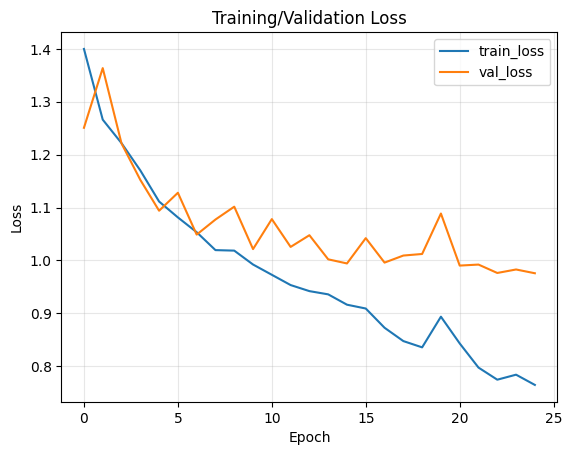

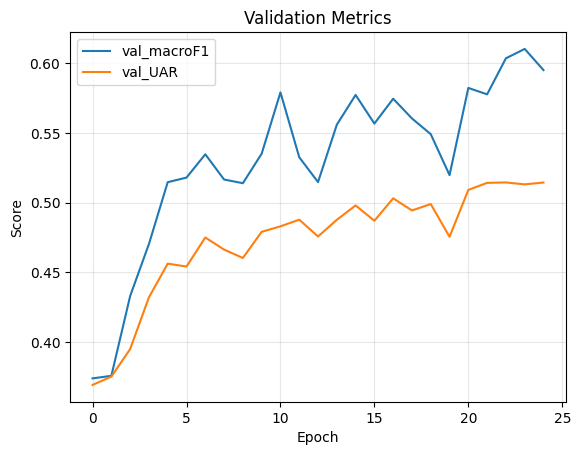

In [37]:
# Plot learning curves
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training/Validation Loss")
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.plot(history["val_f1"], label="val_macroF1")
plt.plot(history["val_uar"], label="val_UAR")
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.title("Validation Metrics")
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

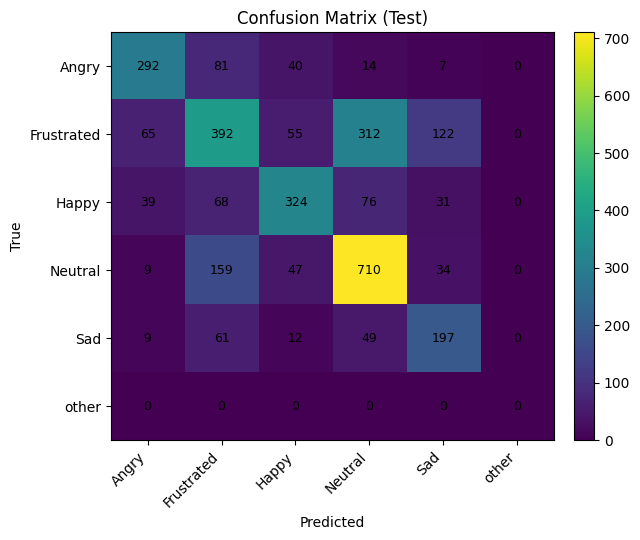

In [38]:
# Plot confusion matrix
labels_order = [k for k,_ in sorted(label_map.items(), key=lambda kv: kv[1])]
fig, ax = plt.subplots(figsize=(6.5, 5.5))
im = ax.imshow(test_cm, interpolation='nearest', aspect='auto')
ax.set_title("Confusion Matrix (Test)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticks(range(len(labels_order))); ax.set_xticklabels(labels_order, rotation=45, ha='right')
ax.set_yticks(range(len(labels_order))); ax.set_yticklabels(labels_order)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
for i in range(test_cm.shape[0]):
    for j in range(test_cm.shape[1]):
        ax.text(j, i, int(test_cm[i, j]), ha="center", va="center", fontsize=9)
plt.tight_layout()
plt.show()

In [39]:
# Save artifacts for the report
report_dir = PROJECT_DIR / "report_artifacts"
report_dir.mkdir(exist_ok=True)
with open(report_dir / "test_metrics.json", "w") as f:
    json.dump({
        "test_loss": float(test_loss),
        "test_macro_f1": float(test_f1),
        "test_uar": float(test_uar),
        "label_map": label_map
    }, f, indent=2)

In [40]:
# Save confusion matrix as PNG
fig, ax = plt.subplots(figsize=(6.5, 5.5))
im = ax.imshow(test_cm, interpolation='nearest', aspect='auto')
ax.set_title("Confusion Matrix (Test)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticks(range(len(labels_order))); ax.set_xticklabels(labels_order, rotation=45, ha='right')
ax.set_yticks(range(len(labels_order))); ax.set_yticklabels(labels_order)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
for i in range(test_cm.shape[0]):
    for j in range(test_cm.shape[1]):
        ax.text(j, i, int(test_cm[i, j]), ha="center", va="center", fontsize=9)
plt.tight_layout()
cm_path = report_dir / "confusion_matrix.png"
plt.savefig(cm_path, dpi=140)
plt.close(fig)

print("Saved artifacts to:", report_dir)

Saved artifacts to: /content/emotion_ser/report_artifacts
